In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
# read case
print(os.getcwd())
case = os.getcwd().split(os.sep)[-1]
print(case)

/home/lena/Promotion/neurolib/GUI/current/gui/data/00110
00110


### Bistability

In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

#####################################################
def getclosest(k_, found_solution, exc, inh, already_tried_):
    import numpy as np
    if len(found_solution) == 0:
        print("no solutions found")
        return -1
    
    start_ind = -1
    for j_ in found_solution:
        if j_ not in already_tried_ and j_ != k_:
            start_ind = j_
            break
            
    if start_ind == -1:
        return -1
        
    min_dist = np.sqrt((exc[k_] - exc[start_ind])**2 + (inh[k_] - inh[start_ind])**2)
    min_i = start_ind
        
    print(found_solution, already_tried_)
        
    if len(found_solution) == len(already_tried_):
        print("already tried all options")
        min_i = -1
        return min_i
    
    for i_ in found_solution:
        if i_ not in already_tried_:
            if i_ != k_ and i_ != min_i:
                dist_ = np.sqrt((exc[k_] - exc[i_])**2 + (inh[k_] - inh[i_])**2)
                if dist_ < min_dist:
                    min_dist = dist_
                    min_i = i_
                    
    if min_i == 0 and 0 in already_tried_:
        return -1
    
    return min_i

In [4]:
##### LOAD BOUNDARIES
data_file = 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))
#plt.scatter(exc, inh)

147


In [5]:
bestControl_init = [None] * len(exc)
bestState_init = [None] * len(exc)
cost_init = [None] * len(exc)
runtime_init = [None] * len(exc)
grad_init = [None] * len(exc)
phi_init = [None] * len(exc)
costnode_init = [None] * len(exc)
weights_init = [None] * len(exc)

conv_init = [[False]*2] * len(exc)

In [7]:
bestControl_0 = [None] * len(exc)
bestState_0 = [None] * len(exc)
cost_0 = [None] * len(exc)
runtime_0 = [None] * len(exc)
grad_0 = [None] * len(exc)
phi_0 = [None] * len(exc)
costnode_0 = [None] * len(exc)
weights_0 = [None] * len(exc)

conv_0 = [[False]*2] * len(exc)

In [8]:
bestControl_1 = [None] * len(exc)
bestState_1 = [None] * len(exc)
cost_1 = [None] * len(exc)
runtime_1 = [None] * len(exc)
grad_1 = [None] * len(exc)
phi_1 = [None] * len(exc)
costnode_1 = [None] * len(exc)
weights_1 = [None] * len(exc)

conv_1 = [[False]*2] * len(exc)

In [9]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [10]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

c_var = [ [0], [1], [0,1]]
p_var = [ [0], [0], [0]]

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

if case[0] == '0':    # low to high
    max_I = [3., -3.]
elif case[0] == '1':
    max_I = [-3., 3.]
    
if case[1] == '0':    # sparsity
    factor_ws = 1.
    factor_we = 0.
elif case[1] == '1':  # energy
    factor_ws = 0.
    factor_we = 1.
    
if case[3] == '0':
    cntrl_vars_init = [0]
elif case[3] == '1':
    cntrl_vars_init = [1]
elif case[3] == '2':
    cntrl_vars_init = [0,1]

if case[4] == '0':
    dur = 100
    trans_time = 0.8
elif case[4] == '1':
    dur = 400
    trans_time = 0.95
    
maxC = [5., -5., 0.18, 0.]

n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [11]:
init_file = 'control_init_' + case + '.pickle'
final_file = 'control_' + case + '.pickle'
case_1 = case[0] + case[1] + '0' + case[3] + case[4]
final_file_1 = 'control_' + case_1 + '.pickle'

In [25]:
if os.path.isfile(init_file) :
    print("file found")
    
    with open(init_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_init = load_array[0]
    bestState_init = load_array[1]
    cost_init = load_array[2]
    runtime_init = load_array[3]
    grad_init = load_array[4]
    phi_init = load_array[5]
    costnode_init = load_array[6]
    weights_init = load_array[7]

file found


In [27]:
# get initial parameters and target states

i_stepsize = 2
limit = 40
start_index = 1
i_range = range(start_index, limit,i_stepsize)
i_range_0 = range(start_index, limit,i_stepsize)
i_range_1 = range(start_index, limit,i_stepsize)
data.set_parameters(aln)

i_range = [0,10,20,30,40,50]

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    aln.params.duration = dur

    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = target_rates[0]
    target[i][:,1,:] = target_rates[1]

-------  0 0.4000000000000001 0.3500000000000001
-------  10 0.4250000000000001 0.42500000000000016
-------  20 0.4500000000000001 0.4750000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  40 0.5250000000000001 0.5500000000000003
-------  50 0.47500000000000014 0.6000000000000003


In [14]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
    cost.setParams(1.0, 0.0, 0.0)

##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, costnode_init_ = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63437.08739662635
Gradient descend method:  None
RUN  0 , total integrated cost =  63437.08739662635
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63437.08739662635
Gradient descend method:  None
RUN  1 , total integrated cost =  8254.424395300603
RUN  2 , total integrated cost =  172.96356567277368
RUN  3 , total integrated cost =  105.47510890227255
RUN  4 , total integrated cost =  78.10841015165795
RUN  5 , total integrated cost =  55.67888645774245
RUN  6 , total integrated cost =  47.18332369540861
RUN  7 , total integrated cost =  47.18209137256874
RUN  8 , total integrated cost =  47.18006872261613
RUN  9 , total integrated cost =  47.17649458449195
RUN  10 , total integrated cost =  47.16722380156603
RUN  11 , total integrated cost =  47.12106102500733
RUN  12 , total integrated cost =  46.2677179615985
RUN  13 , total integrated cost =  43.97404471700584
RUN  14 , total integrated cost =  43.915192410038415
RUN  15 , total integrated cost =  43.915026484773705
RUN  16 ,

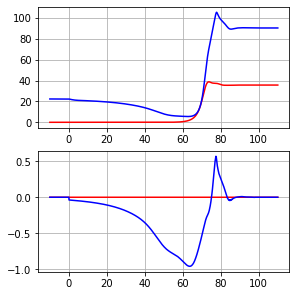

weight =  14445.417634197973
set cost params:  1.0 0.0 14445.417634197973
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62460.709379697
Gradient descend method:  None
RUN  1 , total integrated cost =  56783.22968956709
RUN  2 , total integrated cost =  56783.22968956707
RUN  3 , total integrated cost =  56783.229689567066
RUN  4 , total integrated cost =  56783.229689567066
Control only changes marginally.
RUN  4 , total integrated cost =  56783.229689567066
Improved over  4  iterations in  0.11750425799982622  seconds by  9.089681731945575  percent.


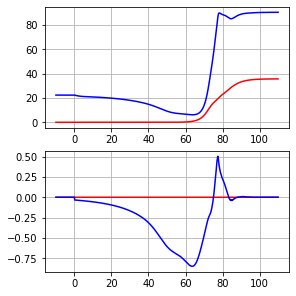

In [16]:
factor_iteration = 20.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    
    #if not type(bestControl_init[i]) == type(None):
    #    continue
        
    control0 = aln.getZeroControl()

    ##### initial guess
    weight_ = 10
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(100 * factor_iteration)

    weights_init[i] = cost.getParams()

    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    if True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_init[i][0,0,:], color = 'red')
        ax[0].plot(time_, bestState_init[i][0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_init[i][0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_init[i][0,1,:], color= 'blue')
        plt.show()
    
    j = 1
    while cost_init[i][-j] == 0.:
        j += 1
    
    weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
    print("weight = ", weight_)
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)
    control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(500 * factor_iteration)

    weights_init[i] = cost.getParams()
    
    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    if True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_init[i][0,0,:], color = 'red')
        ax[0].plot(time_, bestState_init[i][0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_init[i][0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_init[i][0,1,:], color= 'blue')
        plt.show()
        
    with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

In [29]:
#plot initial guesses
for i in [35]:
    print("---------", i)
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i]],
        [costnode_init[i]], [weights_init[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()

--------- 35


TypeError: 'NoneType' object is not subscriptable

In [17]:
found_solution = []
no_solution = []
factor_iteration = 20.
already_tried = [ [] for _ in range(len(exc)) ]

for k in range(len(i_range)**2):
    print('------------------------------------------------------------')
    print('--------------------', k)
    print('------------------------------------------------------------')
        
    print("found solution: ", found_solution)
    print("no solution: ", no_solution)
    
    if len(i_range) == len(found_solution) + len(no_solution):
        print("found solution for all parameters")
        break


    for i in i_range:
        print("------- ", i, exc[i], inh[i])        

        if np.abs(np.mean(bestState_init[i][0,0,-300:]) - target[i][0,0,-1]) < 0.1 * np.abs(
            np.mean(bestState_init[i][0,0,-100:]) - bestState_init[i][0,0,0]) and np.abs(
            np.mean(bestState_init[i][0,1,-300:]) - target[i][0,1,-1]) < 0.1 * np.abs(
            np.mean(bestState_init[i][0,1,-100:]) - bestState_init[i][0,1,0]) and np.amax(
            bestState_init[i][0,0,:]) < target[i][0,0,-1] + 1. and np.amax(
            bestState_init[i][0,1,:]) < target[i][0,1,-1] + 1.:
            # and np.amin(bestState_init[i][0,0,:]) > bestState_init[i][0,0,0] - 1.
            #and np.amin(bestState_init[i][0,1,:]) > bestState_init[i][0,1,0] - 1.:
            if i not in found_solution:
                print("found solution for ", i)
                found_solution.append(i)
            if i in no_solution:
                no_solution.pop(no_solution.index(i))
            continue

        if len(found_solution) == 0:
            continue
            
        closest_ = getclosest(i, found_solution, exc, inh, already_tried[i])
        print("closest index ", closest_)

        weight_ = 10
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
            
        if i != 0 and closest_ != -1:
            control0 = bestControl_init[closest_][:,:,n_pre-1:-n_post+1]
            if closest_ not in already_tried[i]:
                already_tried[i].append(closest_)
                        
        if closest_ == -1:
            print("all options tried already")
            if i not in no_solution:
                no_solution.append(i)
                continue

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(100 * factor_iteration)

        weights_init[i] = cost.getParams()
        
        print("precision vars = ", prec_vars)

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        j = 1
        while cost_init[i][-j] == 0.:
            j += 1

        weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(500 * factor_iteration)

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)

------------------------------------------------------------
-------------------- 0
------------------------------------------------------------
found solution:  []
no solution:  []
-------  20 0.4500000000000001 0.4750000000000002
found solution for  20


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
------------------------------------------------
------------------------- 0
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  20 0.4500000000000001 0.4750000000000002
weight =  16182.601019606802
set cost params:  1.0 0.0 16182.601019606802
interpolate adjoint :  True True True
RUN  

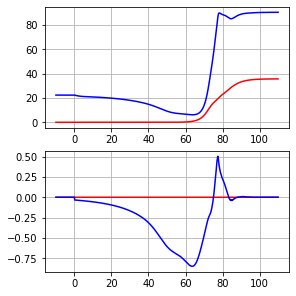

In [24]:
factor_iteration = 20
full_converge = False
conv_init = [[False]*2] * len(exc)

for i in range(len(conv_init)):
    if i not in i_range:
        print(i)
        conv_init[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print("------------------------------------------------")
    print('-------------------------', counter)
    
    if counter > 20:
        break
        
    print(conv_init[start_index:limit:i_stepsize])
    full_converge = True
    
    #for conv in conv_init[start_index:limit:i_stepsize]:
    #    if not conv[0]:
    #        full_converge = False
    #        break
    #    if not conv[1]:
    #        full_converge = False
    #        break
    
    #if full_converge:
    #    print("full convergence")
    #    break

    for i in i_range:        

        print("------- ", i, exc[i], inh[i])
        
        #if conv_init[i] == [True, True]:
        #    continue
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        j = 1
        while cost_init[i][-j] == 0.:
            j += 1
                       
        weight_ = (factor_we * weights_init[i][1] * cost_uncontrolled[i] / cost_init[i][-j]
                   + factor_ws * weights_init[i][2] * cost_uncontrolled[i] / cost_init[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)
            
        if j == cost_init[i].shape[0]-1:
            print("converged for ", i)
            if conv_init[i][0]:
                conv_init[i] = [True, True]
            else:
                conv_init[i] = [True, False]
            #continue
    
        print("no convergence")
        
        if True:
            time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
            fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
            ax[1].plot(time_, bestControl_init[i][0,0,:], color = 'red')
            ax[0].plot(time_, bestState_init[i][0,0,:], color= 'red')
            ax[1].plot(time_, bestControl_init[i][0,1,:], color = 'blue')
            ax[0].plot(time_, bestState_init[i][0,1,:], color= 'blue')
            plt.show()
            
    counter += 1

In [18]:
if os.path.isfile(final_file) :
    print("file found")
    
    with open(final_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_0 = load_array[0]
    bestState_0 = load_array[1]
    cost_0 = load_array[2]
    runtime_0 = load_array[3]
    grad_0 = load_array[4]
    phi_0 = load_array[5]
    costnode_0 = load_array[6]
    weights_0 = load_array[7]

file found


In [19]:
factor_iteration = 20
conv_0 = [[False]*2] * len(exc)
full_converge = False

for i in range(len(conv_0)):
    if i not in i_range_0:
        conv_0[i] = [True, True]

counter = 0

while full_converge == False:
    print('---------------', counter)
    
    if counter > 20:
        break
    
    print(conv_0[::i_stepsize])
    full_converge = True
    
    for conv in conv_0[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break
        
    counter += 1
    
    for i in i_range_0:
        print("------- ", i, exc[i], inh[i])
        
        if conv_0[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.

    # exc and inh control current 

        setinit(initVars[i], aln)
        aln.params.duration = dur

        if not type(bestControl_0[i]) == type(None):
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1]
        else:
            control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1].copy()
            weights_0[i] = weights_init[i]
            cost_0[i] = cost_init[i]

        cgv = None
        max_it = 500 * factor_iteration

        j = 1
        while cost_0[i][-j] == 0.:
            j += 1

        weight_ = (factor_we * weights_0[i][1] * cost_uncontrolled[i] / cost_0[i][-j]
                           + factor_ws * weights_0[i][2] * cost_uncontrolled[i] / cost_0[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        weights_0[i] = cost.getParams()

        bestControl_0[i], bestState_0[i], cost_0[i], runtime_0[i], grad_0[i], phi_0[i], costnode_0[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_0,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        with open(final_file,'wb') as f:
            pickle.dump([bestControl_0, bestState_0, cost_0, runtime_0, grad_0, phi_0,
                     costnode_0, weights_0], f)
            
        if j == cost_0[i].shape[0]-1:
            print("converged for ", i)
            if conv_0[i][0]:
                conv_0[i] = [True, True]
            else:
                conv_0[i] = [True, False]
            continue
    
        print("no convergence")

--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5901.393930563886
Control only changes marginally.
RUN  1 , total integrated cost =  5901.393930563886
Improved over  1  iterations in  0.5360316000000012  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62656045650696 -56.626568743997524
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  3360.476839310955
set cost params:  1.0 0.0 3360.476839310955
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5537.060061461092
Gradient descend method:  None
RUN  1 , total integrated cost =  5537.060061461091
RUN  2 , total integrated cost =  5537.06006146109


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  5537.06006146109
Control only changes marginally.
RUN  3 , total integrated cost =  5537.06006146109
Improved over  3  iterations in  1.3418339000000117  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.62520149438092 -56.625191030695746
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
weight =  24852.781316730285
set cost params:  1.0 0.0 24852.781316730285
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13601.719333695793
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13601.719333695793
Control only changes marginally.
RUN  1 , total integrated cost =  13601.719333695793
Improved over  1  iterations in  0.6014349999999808  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67586175157012 -56.67586690700022
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
weight =  5096.268883573492
set cost params:  1.0 0.0 5096.268883573492
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.224945873999
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.224945873999
Control only changes marginally.
RUN  1 , total integrated cost =  9437.224945873999
Improved over  1  iterations in  0.6200934000000018  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.646507791545446 -56.64655242825527
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  36931.24088327514
set cost params:  1.0 0.0 36931.24088327514
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17550.67259277677
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17550.67259277677
Control only changes marginally.
RUN  1 , total integrated cost =  17550.67259277677
Improved over  1  iterations in  0.5231263000000013  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.690577805899736 -56.6905806073913
no convergence
-------  10 0.4250000000000001 0.42500000000000016
weight =  3311.0503909909726
set cost params:  1.0 0.0 3311.0503909909726
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9108.705488440217
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9108.705488440217
Control only changes marginally.
RUN  1 , total integrated cost =  9108.705488440217
Improved over  1  iterations in  0.4811924999999917  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64369631588489 -56.64374227324168
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
weight =  15340.521656486815
set cost params:  1.0 0.0 15340.521656486815
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17570.054830090157
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17570.054830090157
Control only changes marginally.
RUN  1 , total integrated cost =  17570.054830090157
Improved over  1  iterations in  0.4790050000000008  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.689474650316114 -56.68947729243195
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
weight =  2495.6520068069663
set cost params:  1.0 0.0 2495.6520068069663
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8792.652372215814
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8792.652372215814
Control only changes marginally.
RUN  1 , total integrated cost =  8792.652372215814
Improved over  1  iterations in  0.5569287000000145  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.641883581168734 -56.641918603800605
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
weight =  8973.205250018676
set cost params:  1.0 0.0 8973.205250018676
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17338.965650538285
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17338.965650538285
Control only changes marginally.
RUN  1 , total integrated cost =  17338.965650538285
Improved over  1  iterations in  0.6931608000000153  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68841931779417 -56.68842230399403
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  735.5601320228589
set cost params:  1.0 0.0 735.5601320228589
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3666.1750494144794
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3666.1750494144794
Control only changes marginally.
RUN  1 , total integrated cost =  3666.1750494144794
Improved over  1  iterations in  0.5776225000000181  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64003034328377 -56.64000781278161
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
weight =  3514.0456562958484
set cost params:  1.0 0.0 3514.0456562958484
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12734.492566630535
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12734.492566630535
Control only changes marginally.
RUN  1 , total integrated cost =  12734.492566630535
Improved over  1  iterations in  0.5731964999999946  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.668329572243344 -56.66834633913388
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
weight =  10924.66976649676
set cost params:  1.0 0.0 10924.66976649676
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21563.203779932952
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21563.203779932952
Control only changes marginally.
RUN  1 , total integrated cost =  21563.203779932952
Improved over  1  iterations in  0.5066536999999869  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69835996911231 -56.69836095902131
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
weight =  513.4056616419335
set cost params:  1.0 0.0 513.4056616419335
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2975.1866307933387
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2975.1866307933387
Control only changes marginally.
RUN  1 , total integrated cost =  2975.1866307933387
Improved over  1  iterations in  0.44306720000000155  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.660524320190824 -56.66051384564873
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
weight =  2815.379282832549
set cost params:  1.0 0.0 2815.379282832549
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12475.25350410244
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12475.25350410244
Control only changes marginally.
RUN  1 , total integrated cost =  12475.25350410244
Improved over  1  iterations in  0.5383487999999943  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66683199605681 -56.66684843550554
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
weight =  7609.262986608585
set cost params:  1.0 0.0 7609.262986608585
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21310.2922095222
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21310.2922095222
Control only changes marginally.
RUN  1 , total integrated cost =  21310.2922095222
Improved over  1  iterations in  0.5635226999999929  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.697827734373206 -56.69782858359614
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
weight =  1370.835164619997
set cost params:  1.0 0.0 1370.835164619997
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7972.501383074911
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7972.501383074911
Control only changes marginally.
RUN  1 , total integrated cost =  7972.501383074911
Improved over  1  iterations in  0.5632305999999971  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.636716159026804 -56.636732046377944
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  3711.667107287623
set cost params:  1.0 0.0 3711.667107287623
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16563.755760756692
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16563.755760756692
Control only changes marginally.
RUN  1 , total integrated cost =  16563.755760756692
Improved over  1  iterations in  0.7939054999999939  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68548287702932 -56.68548886486611
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  9424.884791025443
set cost params:  1.0 0.0 9424.884791025443
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25756.95744330182
Gradient descend method:  None
RUN  1 , total integrated cost =  25756.957443301806
RUN  2 , total integrated cost =  25756.957443301802


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  25756.957443301802
Control only changes marginally.
RUN  3 , total integrated cost =  25756.957443301802
Improved over  3  iterations in  1.8845057000000054  seconds by  7.105427357601002e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.70306585604258 -56.703066652727415
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  1160.3130686636462
set cost params:  1.0 0.0 1160.3130686636462
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7735.00142774919
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7735.00142774919
Control only changes marginally.
RUN  1 , total integrated cost =  7735.00142774919
Improved over  1  iterations in  0.4208193999999992  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63472920481226 -56.634747039299135
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  3146.444995923379
set cost params:  1.0 0.0 3146.444995923379
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16339.435211269765
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16339.435211269765
Control only changes marginally.
RUN  1 , total integrated cost =  16339.435211269765
Improved over  1  iterations in  0.34517569999999864  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.684660363717256 -56.68466569897238
converged for  38
--------------- 1
[[True, False], [True, False], [True, False], [True, False], [False, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [False, False], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, T

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5901.393930563886
Control only changes marginally.
RUN  1 , total integrated cost =  5901.393930563886
Improved over  1  iterations in  0.33391430000000355  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62656045650696 -56.626568743997524
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  3360.4768393109584
set cost params:  1.0 0.0 3360.4768393109584
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5537.060061461097
Gradient descend method:  None
RUN  1 , total integrated cost =  5537.060061461096


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  5537.060061461096
Control only changes marginally.
RUN  2 , total integrated cost =  5537.060061461096
Improved over  2  iterations in  0.6714778000000194  seconds by  1.4210854715202004e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.62520149438092 -56.625191030695746
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  24852.781316730285
set cost params:  1.0 0.0 24852.781316730285
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13601.719333695793
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13601.719333695793
Control only changes marginally.
RUN  1 , total integrated cost =  13601.719333695793
Improved over  1  iterations in  0.5165302999999994  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67586175157012 -56.67586690700022
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
weight =  5096.268883574054
set cost params:  1.0 0.0 5096.268883574054
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.224945875008
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.224945875008
Control only changes marginally.
RUN  1 , total integrated cost =  9437.224945875008
Improved over  1  iterations in  0.4238967999999943  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.646507791545446 -56.64655242825527
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  36931.24089295134
set cost params:  1.0 0.0 36931.24089295134
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17550.672597317665
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17550.672597317665
Control only changes marginally.
RUN  1 , total integrated cost =  17550.672597317665
Improved over  1  iterations in  0.3830952999999795  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.690577805899736 -56.6905806073913
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
weight =  3311.0503909909726
set cost params:  1.0 0.0 3311.0503909909726
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9108.705488440217
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9108.705488440217
Control only changes marginally.
RUN  1 , total integrated cost =  9108.705488440217
Improved over  1  iterations in  0.3620391999999981  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64369631588489 -56.64374227324168
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
weight =  15340.521656486815
set cost params:  1.0 0.0 15340.521656486815
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17570.054830090157
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17570.054830090157
Control only changes marginally.
RUN  1 , total integrated cost =  17570.054830090157
Improved over  1  iterations in  0.3801606000000106  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.689474650316114 -56.68947729243195
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
weight =  2495.6520068107193
set cost params:  1.0 0.0 2495.6520068107193
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8792.652372228806
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8792.652372228806
Control only changes marginally.
RUN  1 , total integrated cost =  8792.652372228806
Improved over  1  iterations in  0.4549061000000165  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.641883581168734 -56.641918603800605
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
weight =  8973.205250018676
set cost params:  1.0 0.0 8973.205250018676
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17338.965650538285
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17338.965650538285
Control only changes marginally.
RUN  1 , total integrated cost =  17338.965650538285
Improved over  1  iterations in  0.4550380999999959  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68841931779417 -56.68842230399403
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  735.5601320228602
set cost params:  1.0 0.0 735.5601320228602
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3666.1750494144862
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3666.1750494144862
Control only changes marginally.
RUN  1 , total integrated cost =  3666.1750494144862
Improved over  1  iterations in  0.33532989999997653  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64003034328377 -56.64000781278161
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
weight =  3514.0456562958484
set cost params:  1.0 0.0 3514.0456562958484
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12734.492566630535
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12734.492566630535
Control only changes marginally.
RUN  1 , total integrated cost =  12734.492566630535
Improved over  1  iterations in  0.32470850000001406  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.668329572243344 -56.66834633913388
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
weight =  10924.669766539302
set cost params:  1.0 0.0 10924.669766539302
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21563.203780016152
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21563.203780016152
Control only changes marginally.
RUN  1 , total integrated cost =  21563.203780016152
Improved over  1  iterations in  0.3974284999999895  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69835996911231 -56.69836095902131
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
weight =  513.4056616419334
set cost params:  1.0 0.0 513.4056616419334
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2975.1866307933383
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2975.1866307933383
Control only changes marginally.
RUN  1 , total integrated cost =  2975.1866307933383
Improved over  1  iterations in  0.3925253999999825  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.660524320190824 -56.66051384564873
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
weight =  2815.37928283255
set cost params:  1.0 0.0 2815.37928283255
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12475.253504102446
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12475.253504102446
Control only changes marginally.
RUN  1 , total integrated cost =  12475.253504102446
Improved over  1  iterations in  0.4830434000000139  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66683199605681 -56.66684843550554
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
weight =  7609.262986608585
set cost params:  1.0 0.0 7609.262986608585
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21310.2922095222
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21310.2922095222
Control only changes marginally.
RUN  1 , total integrated cost =  21310.2922095222
Improved over  1  iterations in  0.5535772000000065  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.697827734373206 -56.69782858359614
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
weight =  1370.835164619997
set cost params:  1.0 0.0 1370.835164619997
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7972.501383074911
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7972.501383074911
Control only changes marginally.
RUN  1 , total integrated cost =  7972.501383074911
Improved over  1  iterations in  0.3812912999999867  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.636716159026804 -56.636732046377944
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  3711.6671072857607
set cost params:  1.0 0.0 3711.6671072857607
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16563.755760748496
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16563.755760748496
Control only changes marginally.
RUN  1 , total integrated cost =  16563.755760748496
Improved over  1  iterations in  0.443613699999986  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68548287702932 -56.68548886486611
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  9424.884791085748
set cost params:  1.0 0.0 9424.884791085748
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25756.957443464955
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25756.957443464955
Control only changes marginally.
RUN  1 , total integrated cost =  25756.957443464955
Improved over  1  iterations in  0.4693345000000022  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70306585604258 -56.703066652727415
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  1160.3130686636462
set cost params:  1.0 0.0 1160.3130686636462
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7735.00142774919
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7735.00142774919
Control only changes marginally.
RUN  1 , total integrated cost =  7735.00142774919
Improved over  1  iterations in  0.4378544000000204  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63472920481226 -56.634747039299135
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  3146.444995923379
set cost params:  1.0 0.0 3146.444995923379
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16339.435211269765
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16339.435211269765
Control only changes marginally.
RUN  1 , total integrated cost =  16339.435211269765
Improved over  1  iterations in  0.35770579999999086  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.684660363717256 -56.68466569897238
converged for  38
--------------- 2
[[True, True], [True, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5537.060061461096
Control only changes marginally.
RUN  1 , total integrated cost =  5537.060061461096
Improved over  1  iterations in  0.34209189999998557  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62520149438092 -56.625191030695746
no convergence
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
weight =  36931.2408930723
set cost params:  1.0 0.0 36931.2408930723
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17550.67259737443
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17550.67259737443
Control only changes marginally.
RUN  1 , total integrated cost =  17550.67259737443
Improved over  1  iterations in  0.3410853999999972  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.690577805899736 -56.6905806073913
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  9424.884791086353
s

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25756.957443466592
Control only changes marginally.
RUN  1 , total integrated cost =  25756.957443466592
Improved over  1  iterations in  0.45666389999999524  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70306585604258 -56.703066652727415
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 3
[[True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5537.060061461096
Control only changes marginally.
RUN  1 , total integrated cost =  5537.060061461096
Improved over  1  iterations in  0.40993290000000115  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62520149438092 -56.625191030695746
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.42500000000000

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25756.957443466606
Control only changes marginally.
RUN  1 , total integrated cost =  25756.957443466606
Improved over  1  iterations in  0.425011000000012  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70306585604258 -56.703066652727415
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 4
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [

In [20]:
"""
for i in i_range_0:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],
        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
"""

'\nfor i in i_range_0:\n    \n    aln.params.ext_exc_current = exc[i] * 5.\n    aln.params.ext_inh_current = inh[i] * 5.\n\n    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],\n        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,\n        dur_pre, dur_post, initVars[i], target[i], \'\', filename_ = \'\', transition_time_ = trans_time,\n        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)\n'

In [21]:
if os.path.isfile(final_file_1) :
    print("file found")
    
    with open(final_file_1,'rb') as f:
        load_array = pickle.load(f)

    bestControl_1 = load_array[0]
    bestState_1 = load_array[1]
    cost_1 = load_array[2]
    runtime_1 = load_array[3]
    grad_1 = load_array[4]
    phi_1 = load_array[5]
    costnode_1 = load_array[6]
    weights_1 = load_array[7]

file found


In [22]:
factor_iteration = 20
full_converge = False

for i in range(len(conv_1)):
    if i not in i_range_1:
        conv_1[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print('---------------', counter)
    if counter > 20:
        break
    
    print(conv_1[::i_stepsize])
    full_converge = True
    
    for conv in conv_1[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range_1:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_1[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        if not type(bestControl_1[i]) == type(None):
            control0 = bestControl_1[i][:,:,n_pre-1:-n_post+1].copy()
        else:
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1].copy()
            cost_1[i] = cost_0[i]
        
        cost.setParams(1.0, 1. * factor_we, 1. * factor_ws)

        setinit(initVars[i], aln)

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_1[i] = cost.getParams()

        bestControl_1[i], bestState_1[i], cost_1[i], runtime_1[i], grad_1[i], phi_1[i], costnode_1[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(final_file_1,'wb') as f:
            pickle.dump([bestControl_1, bestState_1, cost_1, runtime_1, grad_1, phi_1,
                 costnode_1, weights_1], f)
            
        j = 1
        while cost_1[i][-j] == 0.:
            j += 1
            
        if j == cost_1[i].shape[0]-1:
            print("converged for ", i)
            if conv_1[i][0]:
                conv_1[i] = [True, True]
            else:
                conv_1[i] = [True, False]
            continue
    
        print("no convergence")
        
    counter += 1

ERROR:root:Problem in initial value trasfer


--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


Problem in initial value trasfer:  Vmean_exc -56.649097156931944 -56.649097230531005
no convergence
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.5340814545430526
Gradient descend method:  None
RUN  1 , total integrated cost =  0.5340814545430526
Control only changes marginally.
RUN  1 , total integrated cost =  0.5340814545430526
Improved over  1  iterations in  0.12557780000000207  seconds by  0.0  percent.
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.9671640477000554
Gradient descend method:  None
RUN  1 , total integrated cost =  2.9671640477000554
Control only changes marginally.
RUN  1 , total integrated cost =  2.9671640477000554
Improved over  1  iterations in  0.11309029999998188  seconds by  0.0  percent.
converged for  10
-------  12 0.4750000

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  37 , total integrated cost =  3.7347181760057326
Improved over  37  iterations in  1.6153731999999934  seconds by  97.62311343633192  percent.
Problem in initial value trasfer:  Vmean_exc -56.64409622122468 -56.644096518456536
no convergence
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.064842420029291
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  2.064842420029291
Control only changes marginally.
RUN  1 , total integrated cost =  2.064842420029291
Improved over  1  iterations in  0.10039510000001428  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.688520411464665 -56.68852038719867
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17.698924033088467
Gradient descend method:  None
RUN  1 , total integrated cost =  5.023491095451269
RUN  2 , total integrated cost =  5.019293051715878
RUN  3 , total integrated cost =  5.019293051715876
RUN  4 , total integrated cost =  5.019293051715876
Control only changes marginally.
RUN  4 , total integrated cost =  5.019293051715876
Improved over  4  iterations in  0.2963942000000088

ERROR:root:Problem in initial value trasfer


  seconds by  71.64068820041142  percent.
Problem in initial value trasfer:  Vmean_exc -56.63350864178936 -56.63350913638687
no convergence
-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.9193369081268865
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  3.9193369081268865
Control only changes marginally.
RUN  1 , total integrated cost =  3.9193369081268865
Improved over  1  iterations in  0.11532450000001404  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.669061347529926 -56.66906153734876
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  199.5523887408111
Gradient descend method:  None
RUN  1 , total integrated cost =  2.1341440777828256
RUN  2 , total integrated cost =  2.133786046907872
RUN  3 , total integrated cost =  2.1333046057148457
RUN  4 , total integrated cost =  2.1309281019348205
RUN  5 , total integrated cost =  2.1302863975884088
RUN  6 , total integrated cost =  2.130155271890943
RUN  7 , total integrated cost =  2.121951444152426
RUN  8 , total integrated cost =  2.116756579670746
RUN  9 , total integrated cost =  2.116712375397749
RUN  10 , 

ERROR:root:Problem in initial value trasfer


RUN  70 , total integrated cost =  2.067721240196278
Control only changes marginally.
RUN  70 , total integrated cost =  2.067721240196278
Improved over  70  iterations in  3.364681300000001  seconds by  98.96382035151584  percent.
Problem in initial value trasfer:  Vmean_exc -56.698390067015836 -56.69838994347105
no convergence
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.81590726897515
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5.81590726897515
Control only changes marginally.
RUN  1 , total integrated cost =  5.81590726897515
Improved over  1  iterations in  0.12047860000001265  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65154653390053 -56.651547100924745
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  178.5703112071586
Gradient descend method:  None
RUN  1 , total integrated cost =  4.833070294433867
RUN  2 , total integrated cost =  4.824804074847933
RUN  3 , total integrated cost =  4.821572650459734
RUN  4 , total integrated cost =  4.811851803679936
RUN  5 , total integrated cost =  4.801060939857545
RUN  6 , total integrated cost =  4.800216922067751
RUN  7 , total integrated cost =  4.740824961727882
RUN  8 , total integrated cost =  4.738626217821794
RUN  9 , total integrated cost =  4.738563591139187
RUN  10 , tota

ERROR:root:Problem in initial value trasfer


RUN  50 , total integrated cost =  4.722847907161824
Control only changes marginally.
RUN  50 , total integrated cost =  4.722847907161824
Improved over  50  iterations in  2.389464199999992  seconds by  97.35518862277007  percent.
Problem in initial value trasfer:  Vmean_exc -56.66757376509487 -56.66757394052408
no convergence
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.9528701559947392
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.9528701559947392
Control only changes marginally.
RUN  1 , total integrated cost =  2.9528701559947392
Improved over  1  iterations in  0.11479310000001419  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69785375095798 -56.69785376380701
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.958977328222749
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  5.958977328222749
Control only changes marginally.
RUN  1 , total integrated cost =  5.958977328222749
Improved over  1  iterations in  0.10852019999998674  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63791422895159 -56.63791372307347
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.778810232181598
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4.778810232181598
Control only changes marginally.
RUN  1 , total integrated cost =  4.778810232181598
Improved over  1  iterations in  0.13665149999999926  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6856933022803 -56.68569339727631
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  261.1783938704904
Gradient descend method:  None
RUN  1 , total integrated cost =  2.9679122061909653
RUN  2 , total integrated cost =  2.9645462376949956
RUN  3 , total integrated cost =  2.963072095071148
RUN  4 , total integrated cost =  2.9590255007487283
RUN  5 , total integrated cost =  2.957896387827529
RUN  6 , total integrated cost =  2.9574220312730395
RUN  7 , total integrated cost =  2.952937311065301
RUN  8 , total integrated cost =  2.9512472045102163
RUN  9 , total integrated cost =  2.9511297077352783
RUN  10 

ERROR:root:Problem in initial value trasfer


 0 , total integrated cost =  6.824439475783803
Gradient descend method:  None
RUN  1 , total integrated cost =  6.824439475783803
Control only changes marginally.
RUN  1 , total integrated cost =  6.824439475783803
Improved over  1  iterations in  0.12092280000001665  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6360993307499 -56.63609971726236
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  180.47795850950249
Gradient descend method:  None
RUN  1 , total integrated cost =  5.662395379533068
RUN  2 , total integrated cost =  5.58197465986784
RUN  3 , total integrated cost =  5.565932358013779
RUN  4 , total integrated cost =  5.565435608675292
RUN  5 , total integrated cost =  5.564276322136633
RUN  6 , total integrated cost =  5.5605495533926454
RUN  7 , total integrated cost =  5.559965457172022
RUN  8 , total integrated cost =  5.5

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  44 , total integrated cost =  5.509246804361912
Improved over  44  iterations in  2.3913002999999833  seconds by  96.94741294180152  percent.
Problem in initial value trasfer:  Vmean_exc -56.6848516161847 -56.68485166426342
no convergence
--------------- 1
[[True, False], [False, False], [True, False], [False, False], [True, False], [True, False], [True, False], [False, False], [True, False], [False, False], [True, False], [False, False], [True, False], [False, False], [True, False], [True, False], [True, False], [False, False], [True, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tru

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.1056489600735429
Control only changes marginally.
RUN  1 , total integrated cost =  1.1056489600735429
Improved over  1  iterations in  0.13852989999998044  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62762194651364 -56.62762189575834
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.801858095666907
Gradient descend method:  None
RUN  1 , total integrated cost =  1.801858095666907
Control only changes marginally.
RUN  1 , total integrated cost =  1.801858095666907
Improved over  1  iterations in  0.15914390000000367  seconds by  0.0  percent.
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.5927285424041204
Gradient descend method:  None
RUN  1 , total integrated cost =  0.5927285424

ERROR:root:Problem in initial value trasfer


 , total integrated cost =  2.13786390950378
RUN  6 , total integrated cost =  2.13786390950378
Control only changes marginally.
RUN  6 , total integrated cost =  2.13786390950378
Improved over  6  iterations in  0.598436300000003  seconds by  5.400124791776761e-13  percent.
Problem in initial value trasfer:  Vmean_exc -56.64909715690965 -56.64909723050905
no convergence
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.5340814545430526
Gradient descend method:  None
RUN  1 , total integrated cost =  0.5340814545430526
Control only changes marginally.
RUN  1 , total integrated cost =  0.5340814545430526
Improved over  1  iterations in  0.15527619999997455  seconds by  0.0  percent.
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.9671640477000554
Gradient descen

ERROR:root:Problem in initial value trasfer


converged for  12
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.7347181760057326
Gradient descend method:  None
RUN  1 , total integrated cost =  3.7347181760057326
Control only changes marginally.
RUN  1 , total integrated cost =  3.7347181760057326
Improved over  1  iterations in  0.13143239999999423  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64409622122468 -56.644096518456536


ERROR:root:Problem in initial value trasfer


converged for  14
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.064842420029291
Gradient descend method:  None
RUN  1 , total integrated cost =  2.064842420029291
Control only changes marginally.
RUN  1 , total integrated cost =  2.064842420029291
Improved over  1  iterations in  0.14049330000000282  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.688520411464665 -56.68852038719867


ERROR:root:Problem in initial value trasfer


converged for  16
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.019293051715876
Gradient descend method:  None
RUN  1 , total integrated cost =  5.019293051715876
Control only changes marginally.
RUN  1 , total integrated cost =  5.019293051715876
Improved over  1  iterations in  0.13827839999999014  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63350864178936 -56.63350913638687


ERROR:root:Problem in initial value trasfer


converged for  18
-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.9193369081268865
Gradient descend method:  None
RUN  1 , total integrated cost =  3.9193369081268865
Control only changes marginally.
RUN  1 , total integrated cost =  3.9193369081268865
Improved over  1  iterations in  0.15258529999999837  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.669061347529926 -56.66906153734876


ERROR:root:Problem in initial value trasfer


converged for  20
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.067721240196278
Gradient descend method:  None
RUN  1 , total integrated cost =  2.067721240196278
Control only changes marginally.
RUN  1 , total integrated cost =  2.067721240196278
Improved over  1  iterations in  0.11748750000000996  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.698390067015836 -56.69838994347105


ERROR:root:Problem in initial value trasfer


converged for  22
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.81590726897515
Gradient descend method:  None
RUN  1 , total integrated cost =  5.81590726897515
Control only changes marginally.
RUN  1 , total integrated cost =  5.81590726897515
Improved over  1  iterations in  0.1284810999999877  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65154653390053 -56.651547100924745


ERROR:root:Problem in initial value trasfer


converged for  24
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.722847907161824
Gradient descend method:  None
RUN  1 , total integrated cost =  4.722847907161824
Control only changes marginally.
RUN  1 , total integrated cost =  4.722847907161824
Improved over  1  iterations in  0.1266659000000061  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66757376509487 -56.66757394052408


ERROR:root:Problem in initial value trasfer


converged for  26
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.9528701559947392
Gradient descend method:  None
RUN  1 , total integrated cost =  2.9528701559947392
Control only changes marginally.
RUN  1 , total integrated cost =  2.9528701559947392
Improved over  1  iterations in  0.12536270000001082  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69785375095798 -56.69785376380701


ERROR:root:Problem in initial value trasfer


converged for  28
-------  30 0.4250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.958977328222749
Gradient descend method:  None
RUN  1 , total integrated cost =  5.958977328222749
Control only changes marginally.
RUN  1 , total integrated cost =  5.958977328222749
Improved over  1  iterations in  0.12345099999998865  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63791422895159 -56.63791372307347


ERROR:root:Problem in initial value trasfer


converged for  30
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.778810232181598
Gradient descend method:  None
RUN  1 , total integrated cost =  4.778810232181598
Control only changes marginally.
RUN  1 , total integrated cost =  4.778810232181598
Improved over  1  iterations in  0.1115077000000042  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6856933022803 -56.68569339727631
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.9047376282920103
Gradient descend method:  None
RUN  1 , total integrated cost =  2.9047376282920103
Control only changes marginally.
RUN  1 , total integrated cost =  2.9047376282920103
Improved over  1  iterations in  0.12791489999997907  seconds by  0.0  percent.


ERROR:root:Problem in initial value trasfer


converged for  34
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6.824439475783803
Gradient descend method:  None
RUN  1 , total integrated cost =  6.824439475783803
Control only changes marginally.
RUN  1 , total integrated cost =  6.824439475783803
Improved over  1  iterations in  0.13548410000001354  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6360993307499 -56.63609971726236
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.509246804361912
Gradient descend method:  None
RUN  1 , total integrated cost =  5.509246804361912
Control only changes marginally.
RUN  1 , total integrated cost =  5.509246804361912
Improved over  1  iterations in  0.16124659999999835  seconds by 

ERROR:root:Problem in initial value trasfer


 0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6848516161847 -56.68485166426342
converged for  38
--------------- 2
[[True, True], [True, False], [True, True], [False, False], [True, True], [True, True], [True, True], [True, False], [True, True], [True, False], [True, True], [True, False], [True, True], [True, False], [True, True], [True, True], [True, True], [True, False], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.13786390950378
Control only changes marginally.
RUN  1 , total integrated cost =  2.13786390950378
Improved over  1  iterations in  0.16917779999999993  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64909715690965 -56.64909723050905
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.7347181760057326
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3.7347181760057326
Control only changes marginally.
RUN  1 , total integrated cost =  3.7347181760057326
Improved over  1  iterations in  0.1408550999999818  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64409622122468 -56.644096518456536
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.019293051715876
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5.019293051715876
Control only changes marginally.
RUN  1 , total integrated cost =  5.019293051715876
Improved over  1  iterations in  0.11141460000001757  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63350864178936 -56.63350913638687
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.067721240196278
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.067721240196278
Control only changes marginally.
RUN  1 , total integrated cost =  2.067721240196278
Improved over  1  iterations in  0.13058840000002192  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.698390067015836 -56.69838994347105
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.722847907161824
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4.722847907161824
Control only changes marginally.
RUN  1 , total integrated cost =  4.722847907161824
Improved over  1  iterations in  0.11863119999998162  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66757376509487 -56.66757394052408
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.9047376282920103
Gradient descend method:  None
RUN  1 , total integrated cost =  2.9047376282920103
Control only changes marginally.
RUN  1 , total integrated cost =  2.9047376282920103
Improved over  1  iterations in  0.11950909999998771  seconds by  0.0  percent.
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.55000000

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5.509246804361912
Control only changes marginally.
RUN  1 , total integrated cost =  5.509246804361912
Improved over  1  iterations in  0.12352959999998347  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6848516161847 -56.68485166426342
converged for  38
--------------- 3
[[True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.13786390950378
Control only changes marginally.
RUN  1 , total integrated cost =  2.13786390950378
Improved over  1  iterations in  0.13099159999998733  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64909715690965 -56.64909723050905
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.525000000000000